In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

import xpart as xp

import xtrack as xt
from xtrack.twiss import TwissInit


%matplotlib widget

In [2]:
OPERATION_MODE = 'z'
REFERENCE_PARAMETER = json.load(open('./reference_parameters.json'))

with open(f'./lattices/{OPERATION_MODE}/fccee_{OPERATION_MODE}_thin.json', 'r', encoding='utf-8') as fid:
    loaded_dct = json.load(fid)

line = xt.Line.from_dict(loaded_dct)


Init: interval 2124, total 212329
Loading line from dict: 100% (212329/212329 iterations)
Done loading line from dict.           


In [3]:
# build tracker for thick line, run twiss and check optics
ref_particle = xp.Particles(
        mass0=xp.ELECTRON_MASS_EV,
        q0=1,
        p0c=REFERENCE_PARAMETER[OPERATION_MODE]['ENERGY']*1e9,
        # p0c=30*1e9,
        x=0,
        y=0
        )



line.particle_ref = ref_particle
line.config.XTRACK_USE_EXACT_DRIFTS = True

line.build_tracker()
thin_twiss = line.twiss().to_pandas()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [4]:
def init_line(line, parameter_dict, ref_particle):
    xline = line.copy()
    xline.particle_ref = ref_particle
    xline.config.XTRACK_USE_EXACT_DRIFTS = True
    xline.build_tracker()

    xline.vars['crabbing']=parameter_dict['crabbing']
    xline.vars['rf_on']=parameter_dict['rf_on']
    if parameter_dict['method']=='4d':
        xline.freeze_longitudinal()
        xline.twiss_default['method'] = '4d'

    if parameter_dict['radiation_element'] is not None:
        elements = parameter_dict['radiation_element']
        xline.configure_radiation(model='mean', elements=elements)
    
    xline.vars['rf_lag']=0.5 * parameter_dict['rf_on']

    if parameter_dict['tapering']:
        xline.compensate_radiation_energy_loss()

    kqx02l=xline.vars['kqx02l']._value
    kqx01l=xline.vars['kqx01l']._value
    kqx00l=xline.vars['kqx00l']._value
    kqx02r=xline.vars['kqx02r']._value
    kqx01r=xline.vars['kqx01r']._value
    kqx00r=xline.vars['kqx00r']._value
    kqy04l=xline.vars['kqy04l']._value
    kqy03l=xline.vars['kqy03l']._value
    kqy02l=xline.vars['kqy02l']._value
    kqy01l=xline.vars['kqy01l']._value
    kqy04r=xline.vars['kqy04r']._value
    kqy03r=xline.vars['kqy03r']._value
    kqy02r=xline.vars['kqy02r']._value
    kqy01r=xline.vars['kqy01r']._value


    xline.vars['kqx02l']= kqx02l + parameter_dict['ccsxl_r12']*-0.407962053786E-4
    xline.vars['kqx01l']= kqx01l + parameter_dict['ccsxl_r12']*0.204592523614E-4
    xline.vars['kqx00l']= kqx00l + parameter_dict['ccsxl_r12']*-0.563876544802E-5

    xline.vars['kqx02r']= kqx02r + parameter_dict['ccsxr_r12']*-0.232141214338E-4
    xline.vars['kqx01r']= kqx01r + parameter_dict['ccsxr_r12']*-0.729876354182E-6
    xline.vars['kqx00r']= kqx00r + parameter_dict['ccsxr_r12']*-0.277011390735E-5

    xline.vars['kqy04l']= kqy04l + parameter_dict['ccsyl_r12']*-0.264551070565E-4 +parameter_dict['ccsyl_r34']*-0.102900786475E-4
    xline.vars['kqy03l']= kqy03l + parameter_dict['ccsyl_r12']*0.975072843514E-5  +parameter_dict['ccsyl_r34']*0.249924762513E-4
    xline.vars['kqy02l']= kqy02l + parameter_dict['ccsyl_r12']*-0.192094267154E-4 +parameter_dict['ccsyl_r34']*0.143914101611E-5
    xline.vars['kqy01l']= kqy01l + parameter_dict['ccsyl_r12']*0.837632335407E-5  +parameter_dict['ccsyl_r34']*-0.185482910485E-4

    xline.vars['kqy04r']= kqy04r + parameter_dict['ccsyr_r12']*-0.798274989431E-4 + parameter_dict['ccsyr_r34']* -0.133557820025E-4 
    xline.vars['kqy03r']= kqy03r + parameter_dict['ccsyr_r12']*0.285355821858E-4  + parameter_dict['ccsyr_r34']* 0.251745961533E-4
    xline.vars['kqy02r']= kqy02r + parameter_dict['ccsyr_r12']*-0.917638881548E-4 + parameter_dict['ccsyr_r34']* -0.692440872725E-6
    xline.vars['kqy01r']= kqy01r + parameter_dict['ccsyr_r12']*0.306308063118E-4  + parameter_dict['ccsyr_r34']* -0.11366344897E-4

    return xline


In [5]:
def track(line, n_part, n_turns, ref_particle, n_sigma=30):
    
    particles = line.build_particles(
        x_norm=np.linspace(0,n_sigma, n_part),
        px_norm=np.zeros(n_part),
        y_norm=np.zeros(n_part),
        py_norm=np.zeros(n_part),
        zeta=0,
        delta=0,
        nemitt_x=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_X']*ref_particle.beta0*ref_particle.gamma0,
        nemitt_y=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_Y']*ref_particle.beta0*ref_particle.gamma0,
    )

    line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

    result_x = line.record_last_track.copy()


    particles = line.build_particles(
        x_norm=np.zeros(n_part),
        px_norm=np.zeros(n_part),
        y_norm=6*np.linspace(0,n_sigma, n_part),
        py_norm=np.zeros(n_part),
        zeta=0,
        delta=0,
        nemitt_x=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_X']*ref_particle.beta0*ref_particle.gamma0,
        nemitt_y=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_Y']*ref_particle.beta0*ref_particle.gamma0,
    )

    line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

    result_y = line.record_last_track.copy()


    particles = line.build_particles(
        x_norm=np.linspace(0,n_sigma, n_part)*0.7,
        px_norm=np.zeros(n_part),
        y_norm=6*np.linspace(0,n_sigma, n_part)*0.7,
        py_norm=np.zeros(n_part),
        zeta=0,
        delta=0,
        nemitt_x=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_X']*ref_particle.beta0*ref_particle.gamma0,
        nemitt_y=REFERENCE_PARAMETER[OPERATION_MODE]['EMITTANCE_Y']*ref_particle.beta0*ref_particle.gamma0,
    )

    line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)
    result_xy = line.record_last_track.copy()


    return result_x, result_y, result_xy



In [6]:
def amplitude_twiss(line, x_max, y_max, n_part, parameter_dict):
    x_range = np.linspace(0,x_max, n_part)
    y_range = np.linspace(0,y_max, n_part)

    results = pd.DataFrame()
    for x, y in zip(x_range, y_range):

        twiss_irx = line.twiss(
                ele_start='ccs_xl.d',
                ele_stop='ccs_xr.d',
                twiss_init=TwissInit(
                        betx=1,
                        bety=1,
                        dx=0,
                        x=x,
                        y=0,
                    ),
                method=parameter_dict['method'],
            ).to_pandas()
        twiss_iry = line.twiss(
                ele_start='ccs_xl.d',
                ele_stop='ccs_xr.d',
                twiss_init=TwissInit(
                        betx=1,
                        bety=1,
                        dx=0,
                        x=0,
                        y=y,
                    ),
                method=parameter_dict['method'],
            ).to_pandas()
        
        results[f'x_{x}'] = twiss_irx['x']
        results[f'y_{y}'] = twiss_iry['y']
    
    return results.transpose()


In [7]:
def plot_twiss(results, parameter_dict):

    fig, ax =plt.subplots(nrows=2, ncols=1, figsize=(9,9), constrained_layout=True)

    fig.suptitle(f"""
Crabbing {parameter_dict['crabbing']}, RF {parameter_dict['rf_on']}, Method {parameter_dict['method']}, Radiation elements {parameter_dict['radiation_element']},
ccsxl_r12 {parameter_dict['ccsxl_r12']}, ccsxr_r12 {parameter_dict['ccsxr_r12']}, ccsyl_r12 {parameter_dict['ccsyl_r12']}, ccsyr_r12 {parameter_dict['ccsyr_r12']}, ccsyl_r34 {parameter_dict['ccsyl_r34']}, ccsyr_r34 {parameter_dict['ccsyr_r34']},
                 """)

    for idx, data in results.loc[results.index.str.contains('^x')].iterrows():
        ax[0].plot(data, label=f'offset {idx}')

    ax[0].set_ylabel('X')
    ax[0].legend()

    for idx, data in results.loc[results.index.str.contains('^y')].iterrows():
        ax[1].plot(data, label=f'offset {idx}')
        
    ax[1].set_ylabel('Y')
    ax[1].legend()

    plt.show()

In [8]:
def plot_results(results, n_turns, parameter_dict):

    result_x, result_y, result_xy = results
    fig, ax =plt.subplots(nrows=2, ncols=2, figsize=(9,9), constrained_layout=True)

    fig.suptitle(f"""
Crabbing {parameter_dict['crabbing']}, RF {parameter_dict['rf_on']}, Method {parameter_dict['method']}, Radiation elements {parameter_dict['radiation_element']},
ccsxl_r12 {parameter_dict['ccsxl_r12']}, ccsxr_r12 {parameter_dict['ccsxr_r12']}, ccsyl_r12 {parameter_dict['ccsyl_r12']}, ccsyr_r12 {parameter_dict['ccsyr_r12']}, ccsyl_r34 {parameter_dict['ccsyl_r34']}, ccsyr_r34 {parameter_dict['ccsyr_r34']},
                 """)

    for i in range(n_turns):
        ax[0,0].plot(result_x.x[:,i], result_x.px[:,i], linestyle='None', marker='X', label=f'turn {i}')

        ax[1,0].plot(result_y.y[:,i], result_y.py[:,i], linestyle='None', marker='X', label=f'turn {i}')

        ax[0,1].plot(result_xy.x[:,i], result_xy.px[:,i], linestyle='None', marker='X', label=f'turn {i}')
        ax[1,1].plot(result_xy.y[:,i], result_xy.py[:,i], linestyle='None', marker='X', label=f'turn {i}')


    ax[0,0].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    ax[1,1].legend()

    ax[0,0].set_xlabel('X')
    ax[0,0].set_ylabel('PX')

    ax[1,0].set_xlabel('Y')
    ax[1,0].set_ylabel('PY')

    ax[0,1].set_xlabel('X=Y')
    ax[0,1].set_ylabel('PX')

    ax[1,1].set_xlabel('Y=X')
    ax[1,1].set_ylabel('PY')

    plt.show()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


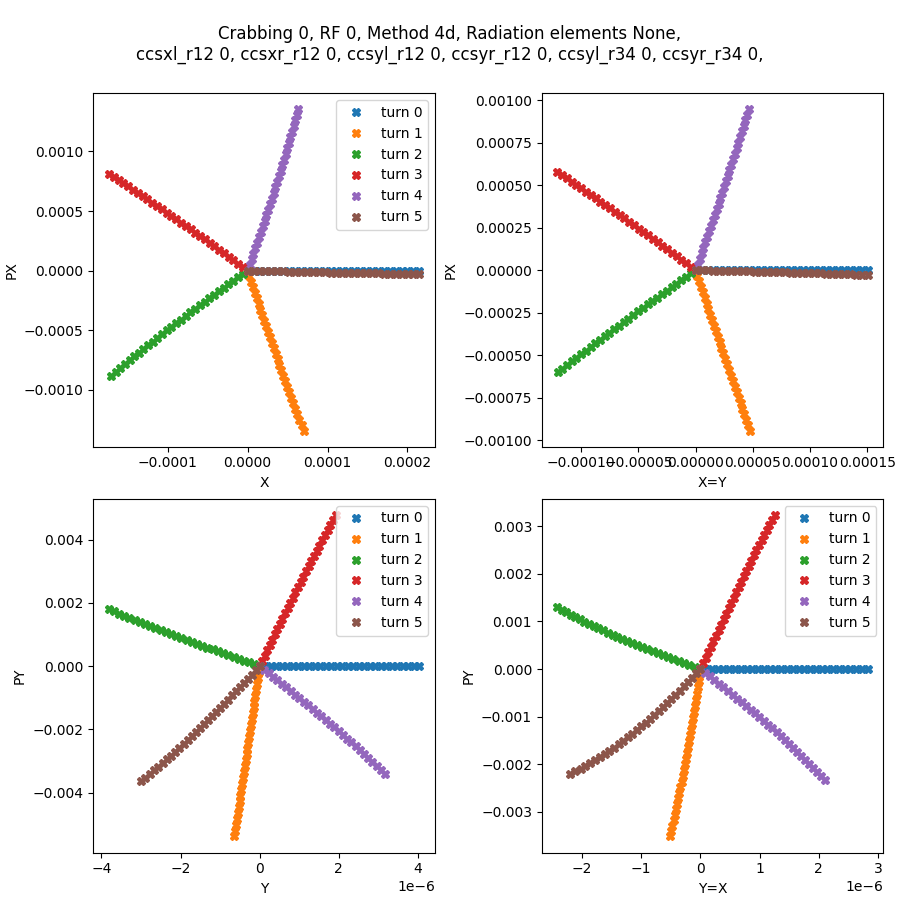

In [9]:
parameter_dict={
        'crabbing':0,
        'rf_on':0,
        'method':'4d',
        'radiation_element':None,
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30

xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )

results = track(xline, n_part, n_turns, ref_particle)

plot_results(results, n_turns, parameter_dict)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


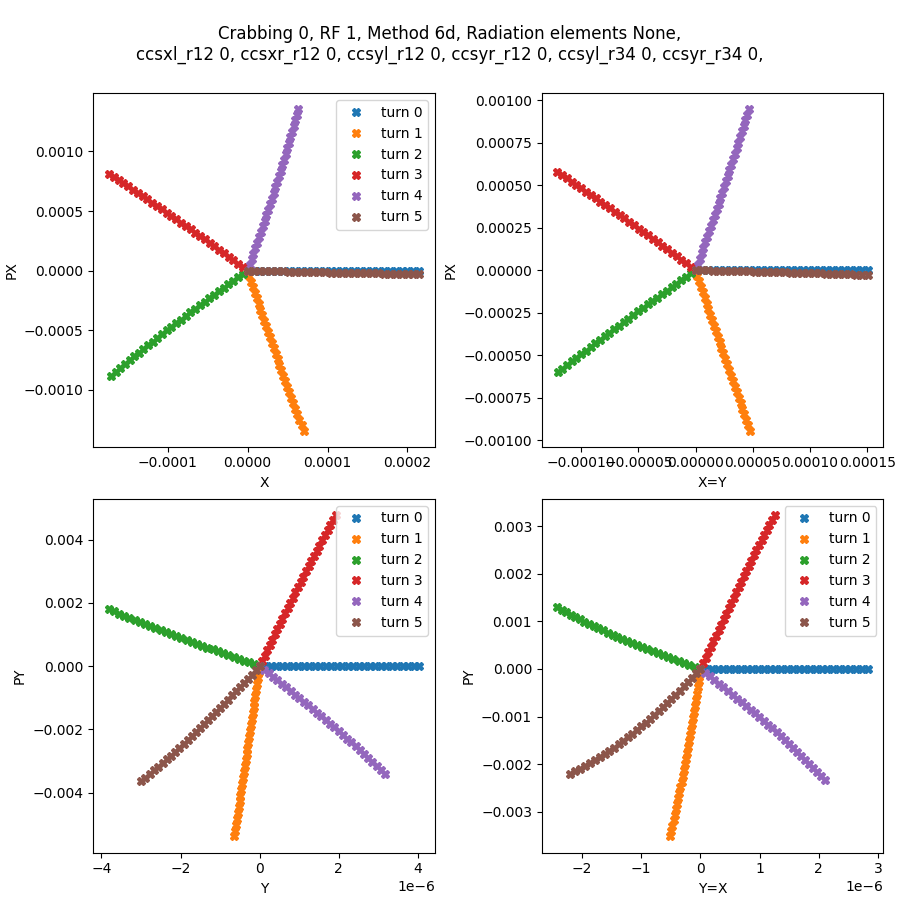

In [10]:
parameter_dict={
        'crabbing':0,
        'rf_on':1,
        'method':'6d',
        'radiation_element':None,
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30

xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )

results = track(xline, n_part, n_turns, ref_particle)

plot_results(results, n_turns, parameter_dict)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


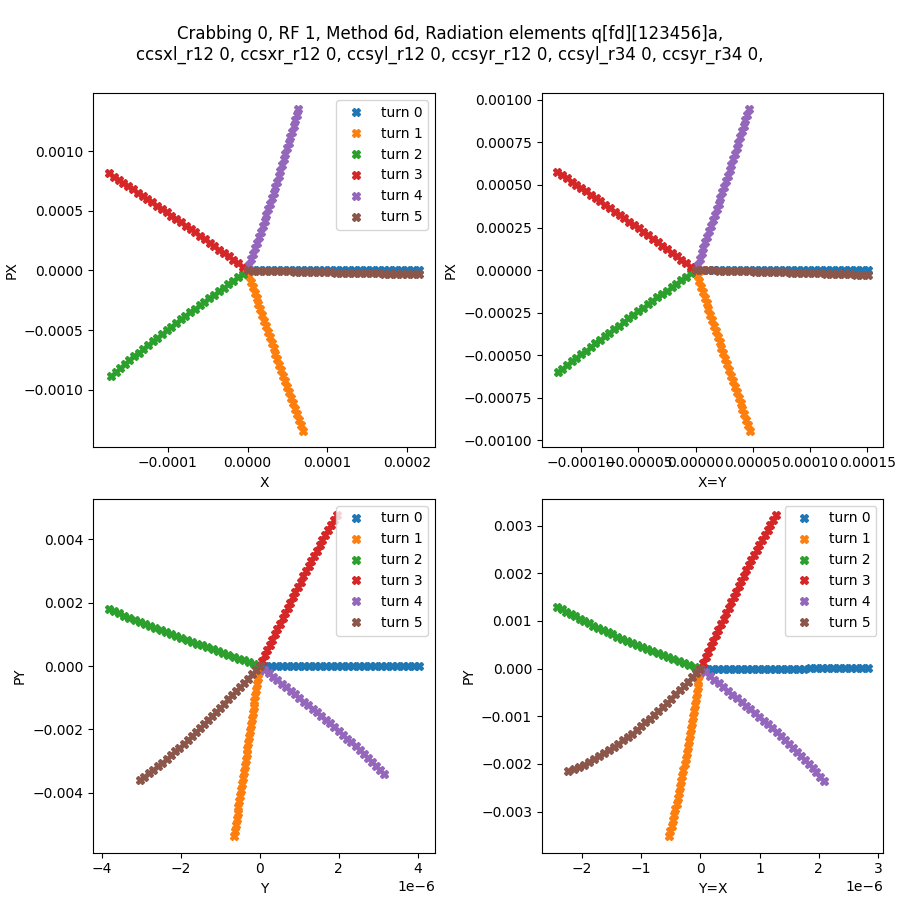

In [11]:

parameter_dict={
        'crabbing':0,
        'rf_on':1,
        'method':'6d',
        'radiation_element':'q[fd][123456]a',
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30
xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )

results = track(xline, n_part, n_turns, ref_particle)

plot_results(results, n_turns, parameter_dict)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


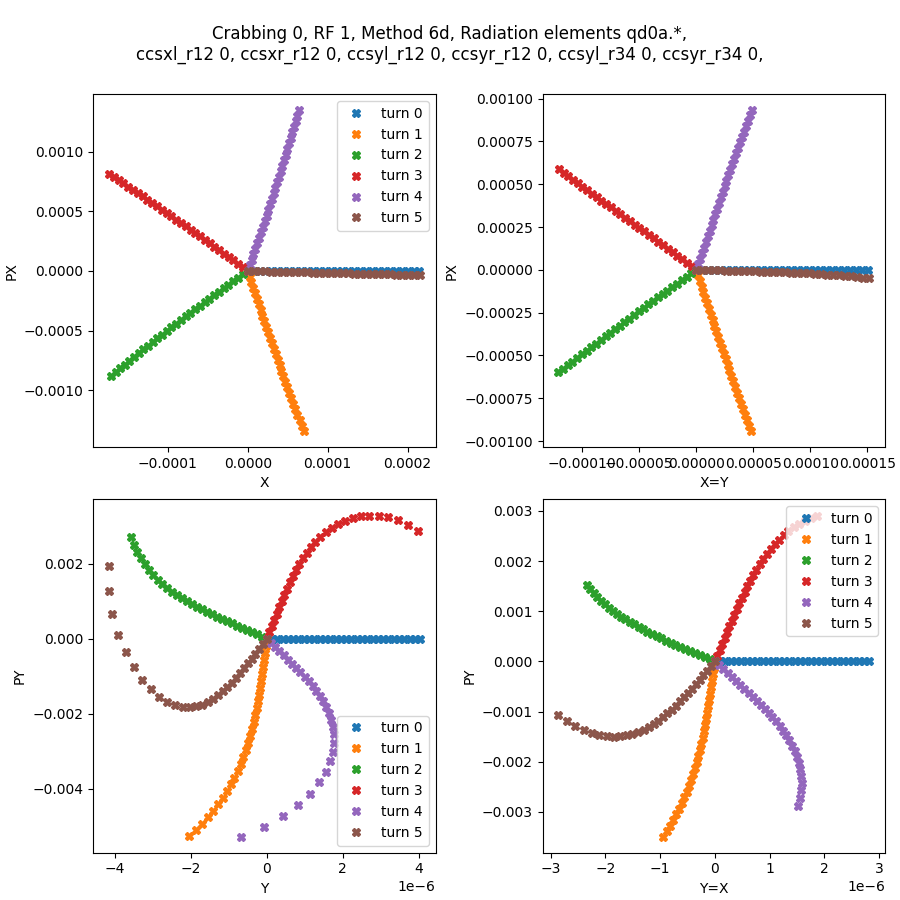

In [12]:

parameter_dict={
        'crabbing':0,
        'rf_on':1,
        'method':'6d',
        'radiation_element':'qd0a.*',
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30
xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )

results = track(xline, n_part, n_turns, ref_particle)

plot_results(results, n_turns, parameter_dict)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_bb3d`.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.


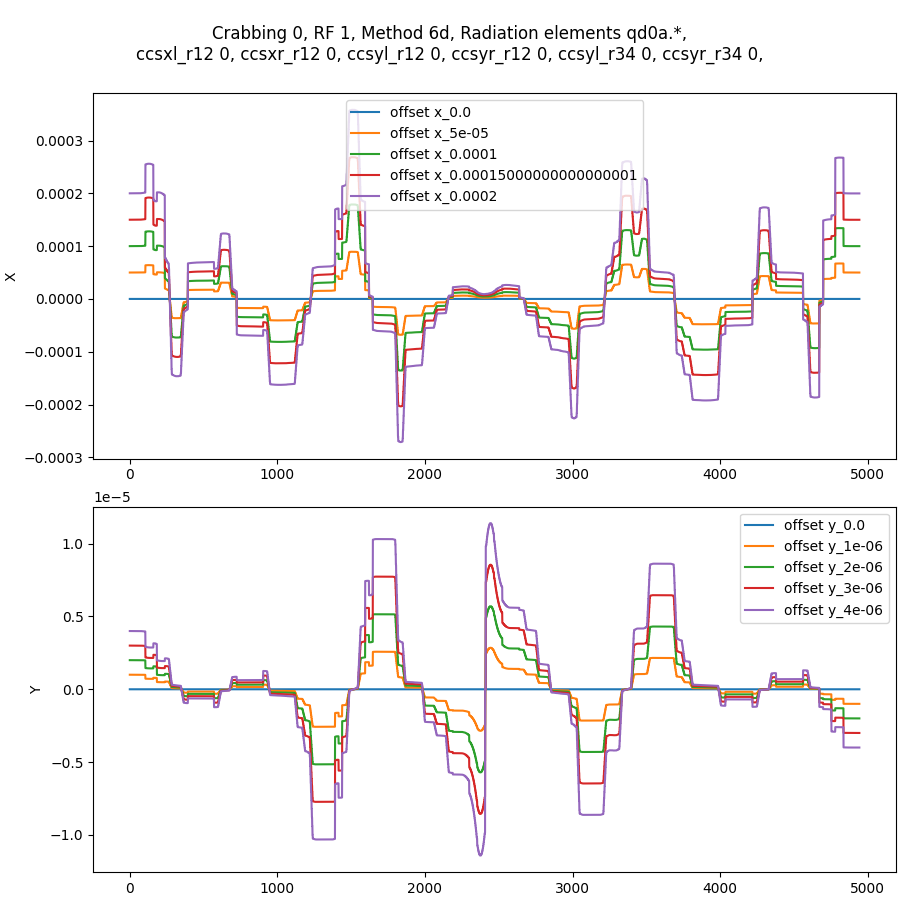

In [13]:
parameter_dict={
        'crabbing':0,
        'rf_on':1,
        'method':'6d',
        'radiation_element':'qd0a.*',
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30
xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )


results = amplitude_twiss(
    xline,
    2e-4,
    4e-6,
    5,
    parameter_dict
)

plot_twiss(results, parameter_dict)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_bb3d`.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.


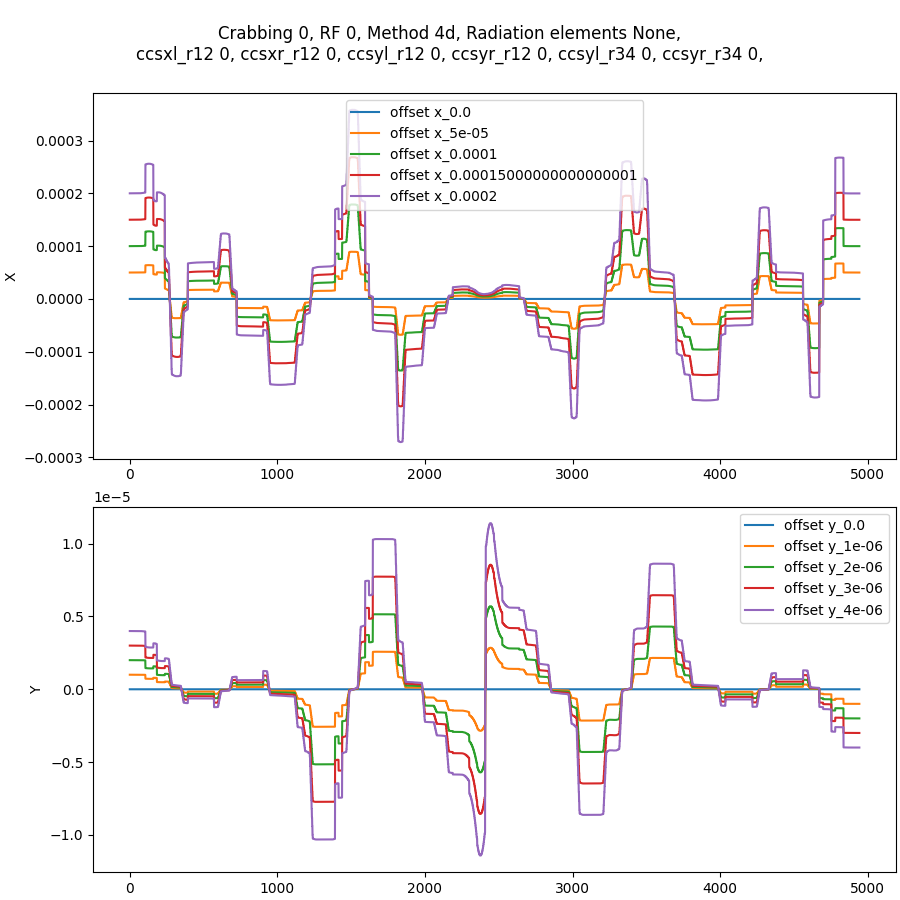

In [14]:
parameter_dict={
        'crabbing':0,
        'rf_on':0,
        'method':'4d',
        'radiation_element':None,
        'tapering':False,
        'ccsxl_r12':0,
        'ccsxr_r12':0,
        'ccsyl_r12':0,
        'ccsyr_r12':0,
        'ccsyl_r34':0,
        'ccsyr_r34':0,
    }
n_turns = 6
n_part = 30
xline = init_line(line,
    parameter_dict=parameter_dict,
    ref_particle=ref_particle
          )


results = amplitude_twiss(
    xline,
    2e-4,
    4e-6,
    5,
    parameter_dict
)

plot_twiss(results, parameter_dict)
